#Llama 2: Leveraging the META Language Model on HuggingFace

Explore the capabilities of the META LLM (Language Model) and its integration with HuggingFace for innovative natural language processing tasks and applications. Join us in harnessing the power of cutting-edge AI for text generation and understanding.

## Install libraries

In [ ]:
#to use the model locally
!pip install -qU transformers accelerate einops langchain xformers bitsandbytes faiss-gpu sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.0/167.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.0 MB/s eta 0:00:00


In [ ]:
#display information about the NVIDIA GPUs installed on your system
!nvidia-smi

Fri Sep 15 11:48:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get access to Huggingface

In [ ]:
#https://huggingface.co/docs/api-inference/quicktour#get-your-api-token

from getpass import getpass

HUGGINGFACEHUB_API_TOKEN = getpass()

··········


This code segment performs the following tasks:

1. Imports the necessary libraries, including cuda (for GPU operations), bfloat16 (a data type for GPU optimization), and transformers (for working with pre-trained language models).

2. Defines the model_id, which specifies the identifier for a pre-trained language model.

3. Determines the device for model execution based on GPU availability. If a GPU is available, it sets the device to be used; otherwise, it falls back to using the CPU.

4. Configures quantization settings using the bitsandbytes library. Quantization is a technique used to reduce the memory and computational requirements of the model.

5. Initializes items related to the Hugging Face (HF) ecosystem, such as authentication using an access token, model configuration, and loads a pre-trained model for causal language modeling.

6. Sets the model in evaluation mode, enabling it for inference.

In summary, this code prepares a pre-trained language model for usage, optimizes it for GPU memory usage through quantization, and ensures it's ready for evaluation and inference tasks.

In [ ]:
from torch import cuda, bfloat16
import transformers

model_id = 'meta-llama/Llama-2-7b-chat-hf'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

# begin initializing HF items, you need an access token
hf_auth = HUGGINGFACEHUB_API_TOKEN #'<add your access token here>'
#create a model configuration object
model_config = transformers.AutoConfig.from_pretrained(
    model_id,
    use_auth_token=hf_auth
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
    use_auth_token=hf_auth
)

# enable evaluation mode to allow model inference (not update the weights)
model.eval()

print(f"Model loaded on {device}")

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/configuration_auto.py:1006: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:479: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Model loaded on cuda:0


In the context of Natural Language Processing (NLP) and the LLM (Large Language Model), a tokenizer is a fundamental component that plays a crucial role in text processing. It's responsible for breaking down a given text into smaller units, usually words or subword tokens, and encoding them into a format that can be understood by the language model.

In [ ]:
#creates the adequate tokenizer automatically
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_id,
    use_auth_token=hf_auth
)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:640: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


 This is a list containing two elements, '\nHuman:' and '\n```\n'. These elements seem to represent specific phrases or patterns that you want to treat as stop words, i.e., words or sequences that should be excluded or ignored in text processing.

In [ ]:

stop_list = ['\nHuman:', '\n```\n']

stop_token_ids = [tokenizer(x)['input_ids'] for x in stop_list]
stop_token_ids

[[1, 29871, 13, 29950, 7889, 29901], [1, 29871, 13, 28956, 13]]

In [ ]:
tokenizer('\nHuman:') #attention mask helps determine the importatn tokens from the just padding tokens

{'input_ids': [1, 29871, 13, 29950, 7889, 29901], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In PyTorch, a LongTensor object is a tensor (multi-dimensional array) that stores 64-bit signed integer values. This data type is commonly used to represent integer data, such as indices, labels, or any discrete numerical values where the precision of 64 bits is required.

In [ ]:


# We have to convert these stop token ids into LongTensor objects.
import torch

stop_token_ids = [torch.LongTensor(x).to(device) for x in stop_token_ids]
stop_token_ids

[tensor([    1, 29871,    13, 29950,  7889, 29901], device='cuda:0'),
 tensor([    1, 29871,    13, 28956,    13], device='cuda:0')]

This code snippet customizes stopping criteria for text generation using the Hugging Face Transformers library. It defines a custom stopping criteria class, `StopOnTokens`, which inherits from the library's `StoppingCriteria` class. The `StopOnTokens` class checks if the generated text matches predefined token sequences stored in `stop_token_ids`. If a match is found, text generation is halted. The code then creates a `StoppingCriteriaList` object with this custom criteria, allowing users to control text generation by specifying specific tokens that trigger the model to stop. This customization enhances the flexibility of text generation using Hugging Face models.

In [ ]:
from transformers import StoppingCriteria, StoppingCriteriaList

# define custom stopping criteria object
class StopOnTokens(StoppingCriteria):
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        for stop_ids in stop_token_ids:
            if torch.eq(input_ids[0][-len(stop_ids):], stop_ids).all():#to compare the ending part of the generated sequence with stop_ids  torch.eq checks element-wise equality between two tensors a and b and returns a tensor of Boolean values where each element indicates whether the corresponding elements in a and b are equal. all checks if all element of the tensor are ==1
                return True
        return False
#init list with one stopping criterion
stopping_criteria = StoppingCriteriaList([StopOnTokens()])

We are ready to initialize the Hugging Face pipeline. There are a few additional parameters that we must define here. Comments are included in the code for further explanation.

In [ ]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

# Callbacks support token-wise streaming
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])
# Verbose is required to pass to the callback manager

from transformers import pipeline, TextStreamer

# Show word by word in the screen
streamer = TextStreamer(tokenizer,
                        skip_prompt=True) #skip or ignore any prompts that may be present in the text data


This code sets up a text generation pipeline using the Hugging Face Transformers library. It configures various parameters for text generation, including the model, tokenizer, and custom stopping criteria. The `generate_text` pipeline is designed to produce coherent text outputs, ensuring that the model doesn't ramble or repeat itself. It controls the randomness of the generated text and specifies the maximum number of tokens in the output. Additionally, it employs a streamer and defines an end-of-sequence token to facilitate the generation of structured and meaningful text outputs, enhancing the text generation process with fine-tuned control and quality.

In [ ]:
generate_text = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    return_full_text=True,  # langchain expects the full text
    task='text-generation',
    # we pass model parameters here too
    stopping_criteria=stopping_criteria,  # without this model rambles during chat
    temperature=0.1,  # 'randomness' of outputs, 0.0 is the min and 1.0 the max
    max_new_tokens=512,  # max number of tokens to generate in the output
    repetition_penalty=1.1,  # without this output begins repeating
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    streamer=streamer,
    eos_token_id=tokenizer.eos_token_id
)

## Test the model

In [ ]:
# Run this code to confirm that everything is working fine.
res = generate_text("What is the restoration forest?")
print(res[0]["generated_text"])


everybody knows that the forest is a place of great beauty and diversity, where many different species of plants and animals live in harmony. But what happens when a forest is damaged or destroyed by human activities? Restoration forestry is the process of rebuilding and restoring degraded or damaged forests to their former state. This can involve planting new trees, removing invasive species, and reintroducing native wildlife. Restoration forestry is important because it helps to maintain biodiversity, improve water quality, and mitigate the effects of climate change. In this article, we will explore the concept of restoration forestry and its importance in protecting our environment.
What is Restoration Forestry?
Restoration forestry is the process of rebuilding and restoring degraded or damaged forests to their former state. This can involve a range of techniques, including:
1. Planting new trees: Trees are essential for maintaining the health and biodiversity of forests. By planti

# Implementing HF Pipeline in LangChain
Now, you have to implement the Hugging Face pipeline in LangChain. You will still get the same output as nothing different is being done here. However, this code will allow you to use LangChain’s advanced agent tooling, chains, etc, with Llama 2.

In [ ]:
from langchain.llms import HuggingFacePipeline

llm = HuggingFacePipeline(pipeline=generate_text)

# checking again that everything is working fine
llm(prompt="What is the restoration forest?")


everybody knows that the forest is a place of great beauty and diversity, but what does it mean to restore a forest? Restoring a forest means rebuilding a complex ecosystem that has been damaged or degraded. This can involve many different activities, such as planting trees, removing invasive species, and reintroducing native animals. Restoration forests are important because they provide many benefits, including clean air and water, habitat for wildlife, and recreational opportunities for people. In this article, we will explore the concept of forest restoration in more detail, including its definition, types, and benefits. Definition of Forest Restoration: Forest restoration is the process of rebuilding a damaged or degraded forest ecosystem. This can involve many different activities, such as planting trees, removing invasive species, and reintroducing native animals. The goal of forest restoration is to return the forest to a healthy and sustainable state, where it can continue to

'\n everybody knows that the forest is a place of great beauty and diversity, but what does it mean to restore a forest? Restoring a forest means rebuilding a complex ecosystem that has been damaged or degraded. This can involve many different activities, such as planting trees, removing invasive species, and reintroducing native animals. Restoration forests are important because they provide many benefits, including clean air and water, habitat for wildlife, and recreational opportunities for people. In this article, we will explore the concept of forest restoration in more detail, including its definition, types, and benefits. Definition of Forest Restoration: Forest restoration is the process of rebuilding a damaged or degraded forest ecosystem. This can involve many different activities, such as planting trees, removing invasive species, and reintroducing native animals. The goal of forest restoration is to return the forest to a healthy and sustainable state, where it can continue

#Ingesting Data using Document Loader


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!sudo -H pip install pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.0/276.0 kB 4.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import PyPDFLoader

directory='/content/drive/MyDrive/Development of a Forest Restoration Chatbot using NLP/Forest_and_Landscape_Restoration/Restoration_Modules/'
# Define the pattern that 'll search in all the subdirectories
pattern = '**/*.pdf'
def load_docs(directory):
  loader = DirectoryLoader(directory,glob=pattern,loader_cls=PyPDFLoader)
  documents = loader.load()
  return documents

In [ ]:
documents = load_docs(directory)
len(documents)

11022

# Splitting in Chunks using Text Splitters

This code performs several text processing tasks. First, it uses the "RecursiveCharacterTextSplitter" to split documents into smaller chunks, each containing 1000 characters with a 20-character overlap. Then, it employs the "HuggingFaceEmbeddings" to generate embeddings for the text using a specific model called "sentence-transformers/all-mpnet-base-v2," utilizing the GPU for processing. Finally, it stores these embeddings in a vector store called "FAISS," derived from the split documents. Essentially, this code prepares text data by splitting it, embedding it, and then storing those embeddings for further analysis or retrieval.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
all_splits = text_splitter.split_documents(documents)

In [ ]:
all_splits

[Document(page_content='Políticas y legislación  \nMario González Espinosa y K arim Musálem  \nMódulo 5  \nRestauración ecológica y sociedad  \n5.1 Filosofía y ética  \n5.2 Actores sociales, construcción de capacidades y educación  \n5.3 Políticas y legislación', metadata={'source': '/content/drive/MyDrive/Development of a Forest Restoration Chatbot using NLP/Forest_and_Landscape_Restoration/Restoration_Modules/Module_5_Policies_Ethics_Restoration/Presentacion 5.3_2019_Politica_Restauracion.pdf', 'page': 0}),
 Document(page_content='módulo 1  \n \nmódulo 2  \n \nmódulo 3  \n \nmódulo 4  \n \nmódulo 5  Fundamentos de la restauración \necológica  \n \n \nRestauración de bosques y selvas  \n \n \nRestauración de ecosistemas \ncosteros, humedales y arrecifes  \n \n \nRestauración de servicios \nambientales  \n \n \nRestauración ecológica y sociedad  2019. Sexta Edición  \n \nDiplomado en línea: Restauración de ecosistemas y \nservicios ambientales  \n \nFundación Internacional para la rest

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings


model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cuda"}

embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)

## **Storing into Qdrant**

In [ ]:
!pip install qdrant_client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.4
    Uninstalling urllib3-2.0.4:
      Successfully uninstalled urllib3-2.0.4
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      S

In [ ]:
from langchain.vectorstores import Qdrant
import qdrant_client
import os

In [ ]:
# create your client to allow us to connect to the cluster

os.environ['QDRANT_HOST'] = "https://5f173491-49bd-4b78-bf45-4f2a997ac4d0.europe-west3-0.gcp.cloud.qdrant.io:6333"
os.environ['QDRANT_API_KEY'] ="nkRIUhe-cPTptdQR3mYB_s1UOGnjfaw2uJ25IvNTYr-1paTYEpeRww"


client = qdrant_client.QdrantClient(
        os.getenv("QDRANT_HOST"),
        api_key=os.getenv("QDRANT_API_KEY")
    )

In [ ]:
#no need to re create the collection its alread created and stored in the cloud





# use the client object to create a collection

os.environ['QDRANT_COLLECTION'] ="docs_collection"

collection_config = qdrant_client.http.models.VectorParams(
        size=768,
        distance=qdrant_client.http.models.Distance.COSINE
    )

client.recreate_collection(
    collection_name=os.getenv("QDRANT_COLLECTION"),
    vectors_config=collection_config
)

True

In [ ]:
!sudo -H pip install pypdf

In [ ]:
#splitting
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
docs = text_splitter.split_documents(all_splits)

In [ ]:
#no need to repopulate the vectore store its already in the cloud



#create the vector store

vectorstore = Qdrant.from_documents(
    docs,
    embeddings,
    url=os.getenv("QDRANT_HOST"),
    prefer_grpc=True,
    api_key=os.getenv("QDRANT_API_KEY"),
    collection_name=os.getenv("QDRANT_COLLECTION_NAME"),
)

# **inspect the content of the created collection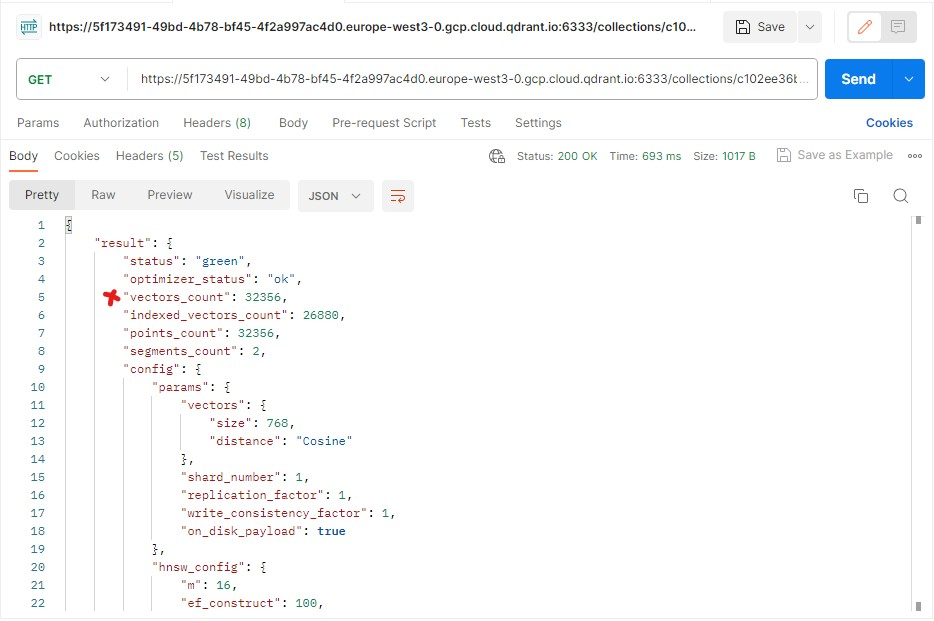**

In [ ]:
info = client.get_collection(collection_name="c102ee36bfe246cf92734d4ad084e153")

print("Collection info:", info)
for get_info in info:
  print(get_info)

Collection info: status=<CollectionStatus.GREEN: 'green'> optimizer_status=<OptimizersStatusOneOf.OK: 'ok'> vectors_count=32446 indexed_vectors_count=26880 points_count=32446 segments_count=2 config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=768, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None), shard_number=1, replication_factor=1, write_consistency_factor=1, on_disk_payload=True), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=1), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), quantization_config=None) payload_schema={}
('status', <CollectionStatus.GREEN: 'green'>)
('optimizer_status', <

# **Upload a new document to Qdrant**

In [ ]:
from langchain.document_loaders import PyPDFLoader
loader = PyPDFLoader("/content/drive/MyDrive/Development of a Forest Restoration Chatbot using NLP/Forest_and_Landscape_Restoration/Restoration_Modules/Module_2_Forest_and_Jungle_Restoration/2.2_Forest_Restoration_Techniques/IRI-forest-restoration-primer-Final.pdf")
pages = loader.load()

# **`split the document`**

In [ ]:
#upload the new doc from drive
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
doc_splits = text_splitter.split_documents(pages)

# **create a database object**

In [ ]:
doc_store = Qdrant(
    client=client, collection_name="c102ee36bfe246cf92734d4ad084e153",
    embeddings=embeddings,
)

In [ ]:
doc_store.add_documents(doc_splits)

['b88aedf71a8f494a94b84bc7f29d5d5d',
 'b6a2694403ee4cbb9a9a59a637274c03',
 'd94b172c2b784c2fa784530e0fa8a87f',
 'ee09189f724e4657916f9f3bf90ebe00',
 '0f7b2a942cb0450f90582179fc72cd0b',
 '9ab717a7e8ab4656b3bc6fd8855e16ef',
 '2069dd7510ea4648b86b64ea127cbd4e',
 '2573e18759954befb95ec1ac0c78f9c8',
 '91723862f2c7447a87a03d72ebde45fe',
 '5ad5d0479b9346e597ad16f6b40f529f',
 '7c94b2a1a4674225ae292ada38721d90',
 '6301d8bea1dc4d21969b901bcd6a2da9',
 'be5beeeedb2540d4a10195be1965c9a6',
 'a22212a47470404cb7202da43bfc5c74',
 '872c1ebce96a44199f5a3bd3b6f1daad',
 '613ef86d342c44baad1c3cbbf495cc2d',
 '602a7da26e8643168bd1de82851f8192',
 'fca5728371334c5da7139243627f4fc5',
 '614c66e78ad1461e9915b3f68acdf9ad',
 '2cda617da78d4edcad2daf4a3e8dc3dc',
 '4913ed714c35462b9d08491da6b351e8',
 '252fdb8a2d43443dbf3f97b3ab408306',
 'bd3494be367c4e9eaea13a7687211cad',
 '1ca50db57dfa454fbaaa4c0766fbc9d1',
 '008b95f9416b4d2b8a830c0561dc5dd4',
 '90e4c6c500e84dd59e9cf680de7f28a3',
 '097eef9708b848dd845e7af04294604b',
 

In [ ]:
#this is for making sure the num of vectors increased

info = client.get_collection(collection_name="c102ee36bfe246cf92734d4ad084e153")

print("Collection info:", info)
for get_info in info:
  print(get_info)

Collection info: status=<CollectionStatus.GREEN: 'green'> optimizer_status=<OptimizersStatusOneOf.OK: 'ok'> vectors_count=32519 indexed_vectors_count=26880 points_count=32519 segments_count=2 config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=768, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None), shard_number=1, replication_factor=1, write_consistency_factor=1, on_disk_payload=True), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=1), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), quantization_config=None) payload_schema={}
('status', <CollectionStatus.GREEN: 'green'>)
('optimizer_status', <

#Initializing Chain

In [ ]:
#here i 've added mmr to ensure the research returnes diverse content about the request
from langchain.chains import ConversationalRetrievalChain

chain = ConversationalRetrievalChain.from_llm(llm, doc_store.as_retriever(search_type="mmr"), return_source_documents=True)

In [ ]:
#Q&A with the newly added document
chat_history = []

query = "How do Orthodox churches in Ethiopia contribute to the conservation of biodiversity and local cultural traditions through the protection of church forests?"
result = chain({"question": query, "chat_history": chat_history})#


result['answer']

Orthodox churches in Ethiopia have protected forests surrounding churches for hundreds of years, conserving unique and precious biodiversity. These church forests have become vital for protecting rare native plants as well as vivid representations of Eden to the local church communities.</s>


' Orthodox churches in Ethiopia have protected forests surrounding churches for hundreds of years, conserving unique and precious biodiversity. These church forests have become vital for protecting rare native plants as well as vivid representations of Eden to the local church communities.'

In [ ]:
print(result['source_documents'])#this references the same document we just uploaded

[Document(page_content='Pg. 2\nForest Restoration• In Indonesia, there are over a dozen “eco-pesantren,” which are  \nIslamic boarding schools that prioritize environmentalism. Among \nthe most prominent is Darul Ulum in Sukabami, West Java, where a \nseven-hectare riverside area was decreed harim —a forbidden zone for \ndevelopment—and 700 trees, including mango, avocado and durian, were \nplanted on-site. Every student at the school is required to plant a tree \nbefore they graduate.\n• Orthodox churches in Ethiopia have protected forests surrounding \nchurches for hundreds of years, conserving unique and precious \nbiodiversity. These church forests have become vital for protecting  \nrare native plants as well as vivid representations of Eden to the local \nchurch communities. • In Colombia, in the department of Chocó, the Catholic Diocese of \nQuibdó has collaborated with the Antonio Anglés School to create \nthe Environmental Center for Ethnocultural Biodiversity of Chocó. As', m